In [1]:
play = False

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import os, sys, camb
from camb import model, initialpower
from astropy import units as u, constants as c
from scipy.interpolate import interp1d
from astropy.cosmology import Planck18 as cosmo

import utils as ut
import props as p
import lines as l
from importlib import reload
reload(ut)
reload(p)
reload(l)

#TIM = p.SpaceTIM
TIM = p.TIM
#TIM = p.TIM2
#GAL = p.AstroDeep
GAL = p.Euclid
CII = l.CII

In [2]:
def quadsum(arr):
    return np.sqrt(np.sum(arr[~np.isnan(arr)]**2))

def galCross_Variance(ngal, numModes, Px, Pg, Pl, Nl):
    crossVar = [(PxG**2 + (NT + PT) * (1/n_gal + Pg)) / (2*nm)
        for n_gal, nm, PxG, Pg, PT, NT in zip(ngal, numModes, Px, Pg, Pl, Nl)]
    return crossVar

def closest(lst, K):
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]

In [3]:
H0 = cosmo.H0.value
h = cosmo.h

sigCoef = np.sqrt(8*np.log(2))
lilh = True

dlnk = 0.8

if play:
    dlnk = 1

colors = ['purple', 'blue', 'gold', 'red']
linestyles = ['-','--',':','-.']

# define our bins
bins = [
    ut.zBin(TIM.SW.zmin, TIM.SW.zcen),
    ut.zBin(TIM.SW.zcen, TIM.SW.zmax),
    ut.zBin(TIM.LW.zmin, TIM.LW.zcen),
    ut.zBin(TIM.LW.zcen, TIM.LW.zmax),
]
bin_zs = [b.center.value for b in bins]
bands = ['SW', 'SW', 'LW', 'LW'] 

LSbins = [ut.Survey(b, TIM[band].ins, TIM.Daz, TIM.Del, lilh) for b, band in zip(bins, bands)]
# LIM survey objects for each bin

sfrds = [ut.MD_sfrd(z) for z in bin_zs]
Iciis = np.array([CII.Inu(sfrd, z).value for sfrd, z in zip(sfrds, bin_zs)])

fs = 0.897 #Proportion of Galaxy sample galaxies that are line emitters
b_CII = 1.7 # TODO: Get an actual value for this and Bgal
b_gal = 1.7 # maintaining b* = b_CII*b_gal = 3
Igal = 1
bstar = b_CII*b_gal

In [4]:
   def numKs (newBins):
    k_xyz_modes = [lsb.k_modes() for lsb in newBins]
    # k_xyz_modes[N] where N is the survey bin
    # each element is a 4D array of shape (3, Nkx, Nky, Nkz)

    # magnitudes of the k vectors
    k_mags = [np.sqrt(np.sum(kxyzs**2, axis=0)) for kxyzs in k_xyz_modes] 

    # minimum k magnitude in each survey bin
    k_mins = [np.min(km[km != 0]) for km in k_mags]
    k_maxs = [np.max(km) for km in k_mags]

    # unit kx, ky, kz vectors for each mode in each survey bin
    #k_props = [np.abs(kxyzs / km) for kxyzs, km in zip(k_xyz_modes, k_mags)]

    # num of k bins given our dlnk
    num_kbins = [round(ut.num_log_steps(k_min, np.max(km), dlnk)) + 1 \
        for k_min, km in zip(k_mins, k_mags)]


    # resolution elements Sigma_perpendicular (transverse) and sigma_par (LoS)
    s_perps = [b.transScale(TIM[band].FWHM).value / sigCoef for b, band in zip(bins, bands)]
    s_pars = [ut.dnu2dr(TIM[band].dnu, b.center).value / sigCoef for b, band in zip(bins, bands)]

    # outer product of the these three gaussians
    windows = [np.einsum('i,j,k->ijk', 
                    np.exp(-kxyzs[0][:, 0, 0]**2 * s_perp**2 / 2), 
                    np.exp(-kxyzs[1][0, :, 0]**2 * s_perp**2 / 2), 
                    np.exp(-kxyzs[2][0, 0, :]**2 * s_par**2 / 2)) 
                    for kxyzs, s_perp, s_par in zip(k_xyz_modes, s_perps, s_pars)]

    # CAMB time, have to remove last redshift because there is a duplication
    # and CAMB doesn't like that

    pars = camb.CAMBparams()
    pars.set_cosmology(H0=H0, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
    pars.InitPower.set_params(ns=0.965, As=2e-9, r=0)
    pars.set_for_lmax(2500, lens_potential_accuracy=0)
    pars.set_matter_power(redshifts=bin_zs[:-1], kmax=np.max(k_maxs) * 3, nonlinear=False) 


    results = camb.get_results(pars)

    binned_results = [results.get_matter_power_spectrum(minkh=kmin, maxkh=np.max(km), npoints=nkb) \
        for kmin, km, nkb in zip(k_mins, k_mags, num_kbins)]

    z_idxs = [np.argmin(np.abs(zs - binz)) for (_, zs, _), binz in zip(binned_results, bin_zs)]

    Pms = [(ks, Pm[z_idx]) for (ks, _, Pm), z_idx in zip(binned_results, z_idxs)]

    kbin_edges = [np.append([0], np.sqrt(ks * np.append(ks[1:], [np.max(km)])))
                for km, (ks, _) in zip(k_mags, Pms)]
    # get bin edges by selecting the midway between each CAMB k prediction
    # use geometric mean because bins are log-spaced

    nModes = []
    for j, (ks,ws) in enumerate(zip(k_mags, windows)):
        kflat = ks.flatten()
        wflat = ws.flatten()
        kNonZero = kflat[np.nonzero(kflat)[0]]
        edges = kbin_edges[j]

        nModeList = []
        for i in np.arange(len(edges)-1):
            #print(i, len(edges))
            if i+1 == len(edges):
                wSum = (np.sum(wflat[kflat>edges[i]]))
            else:
                wSum = (np.sum(wflat[(kflat>edges[i]) & (kflat<=edges[i+1])]))
            nModeList.append(wSum/2.) # accounting for double counting.
        nModeList = np.asarray(nModeList)
        nModes.append(np.asarray(nModeList))
    return nModes, Pms
#window_avgs = [np.array([np.mean(win[np.logical_and(km < kb[i+1], km >= kb[i])]) 
#                for i in range(len(kb)-1)]) 
#        for win, km, kb in zip(windows, k_mags, kbin_edges)]

## Make changes in the cell below

In [5]:
def quadSNR(SWNEI = False, LWNEI = False, numberDensities = [False], area = False, kCut=1, PRatio = False):
    '''
    Calculate the quadature sum of SNR(k) for 4 seperate TIM z bins as a function of TIM NEI and galaxy nGal

    SWNEI: Average Noise equivalent intensity of the short wavelength array in u.Jy / (u.s ** .5)
    LWNEI: Average Noise equivalent intensity of the long wavelength array in u.Jy / (u.s ** .5)
    nGal: len 4 arr - Galaxy number density in Mpc**-3 * h**3 per TIM redshift bin in order of lowest to highest z
    area: survey area.This will always generate a square field of view
    with sides of angle sqrt(area) degrees on a side.
            NOTE above values will default to whatever is saved in the props file for TIM if not individually assigned.

    
    kCut: float/int k mode value that establishes the cuttoff between the clustering and shot regimes. 
    PRatio: Bool - if PRatio is set to True returns the ratio of P_TIM/P_N. Else returns (quadClust, quadShot)

    returns quad_SNRs: len 4 arr quadature sum of SNR(k) for 4 TIM z bins in order of lowest to highest z
    '''
    #TIM.SW.NEI = SWNEI # These don't actually change the NEI in the noise calculation
    #TIM.LW.NEI = LWNEI
    #print(numberDensities)
    if numberDensities[0]:
        GAL.n_gals = numberDensities
    
    if SWNEI:
        TIM['SW'].ins.NEI = SWNEI
        
    if LWNEI:
        TIM['LW'].ins.NEI = LWNEI
    
    if area:
        TIM.Daz = np.sqrt(area) * u.deg
        TIM.Del = np.sqrt(area) * u.deg
        #print(area)
    
    # ***
    #for b, band in zip(bins, bands):
    #    print(TIM[band].ins.NEI)
    
    LSbins = [ut.Survey(b, TIM[band].ins, TIM.Daz, TIM.Del, lilh) for b, band in zip(bins, bands)]
    nModes, Pms = numKs(LSbins)

    x_shots = fs * Iciis / GAL.n_gals # cross shot for TIMxGal
    #where fs is SFRD from the catalogue divided by the corresponding madau dickinson curve point.
    PxGs = [(bstar * Icii * Igal * Pm) #+ x_shot 
                for Icii, x_shot, (_, Pm) in zip(Iciis, x_shots, Pms)]


    TIM_shot = [1.2e9,2.2e9,3e9,3e9] # TODO: Discuss a self consistent way of calculating these values.
    P_TIM = [(b_CII**2 * ICII**2 * Pm + shot) for ICII, (_,Pm), shot in zip(Iciis, Pms, TIM_shot)]
    N_TIM = [lsb.cell_noise(TIM.time).value for lsb, nm in zip(LSbins, nModes)]
    #print(N_TIM[0])
    P_gal = [b_gal**2*Pm for (_,Pm), ngal in zip(Pms, GAL.n_gals)]

    VARx = galCross_Variance(GAL.n_gals, nModes, PxGs, P_gal, P_TIM, N_TIM)
    
    inClust = [np.where(ks <= kCut) for ks, _ in Pms]
    inShot = [np.where(ks > kCut) for ks, _ in Pms]
    
    #threeModes = [np.where(nM >= 3) for nM in nModes]

    SNR_Clust = [PxG[clust] / np.sqrt(VARs[clust])  for PxG, VARs, clust in zip(PxGs, VARx, inClust)]
    SNR_Shot = [PxG[shot] / np.sqrt(VARs[shot])  for PxG, VARs, shot in zip(PxGs, VARx, inShot)]
    
    #sum the SNRs in each bin in quadrature so that we can report a "Total SNR per redshift bin"
    quadClust = [np.sqrt(np.sum(SNRs[~np.isnan(SNRs)]**2)) for SNRs in SNR_Clust]
    quadShot = [np.sqrt(np.sum(SNRs[~np.isnan(SNRs)]**2)) for SNRs in SNR_Shot]
    

    if PRatio: 
        PoNClust = [P_I[clust] / P_N  for P_I, P_N, clust in zip(P_TIM, N_TIM, inClust)]
        PoNShot = [P_I[shot] / P_N  for P_I, P_N, shot in zip(P_TIM, N_TIM, inClust)]
        PoNClust = [np.mean(binClust) for binClust in PoNClust]
        PoNShot = [np.mean(binShot) for binShot in PoNShot]
        #print(PoNShot)
        return PoNClust, PoNShot
    return quadClust, quadShot
        

TIM LW NEI:  39.2758090843254
TIM SW NEI:  64.1340007221665
TIM2 LW NEI:  3.194133716130952
Background limited NEI:  0.13540261810515875


C:\Users\juzz\AppData\Local\Temp\ipykernel_3420\2763819507.py:49: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e3)


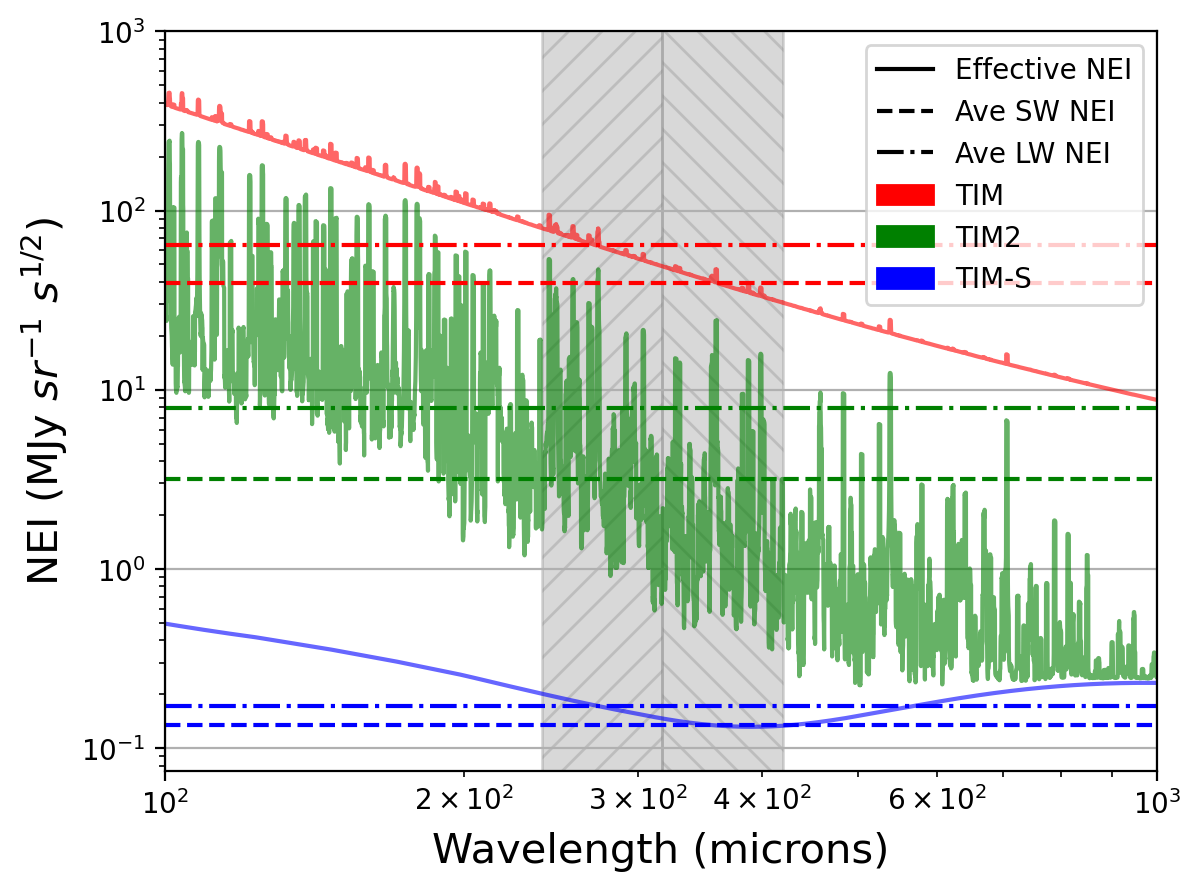

In [6]:
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

BradfordNEIs = np.loadtxt('nei_R250_0p08.txt').T

wavelengths = BradfordNEIs[0]

spaceNEI = BradfordNEIs[3]
TIM2NEI = BradfordNEIs[2]
TIMNEI = BradfordNEIs[1]

inSW = np.where((wavelengths > 240) & (wavelengths < 317))
TIM_SW_NEI = np.mean(TIMNEI[inSW])
TIM2_SW_NEI = np.mean(TIM2NEI[inSW])
TIMS_SW_NEI = np.mean(spaceNEI[inSW])

inLW = np.where((wavelengths > 317) & (wavelengths < 420))
TIM_LW_NEI = np.mean(TIMNEI[inLW])
TIM2_LW_NEI = np.mean(TIM2NEI[inLW])
TIMS_LW_NEI = np.mean(spaceNEI[inLW])

print('TIM LW NEI: ', TIM_LW_NEI)
print('TIM SW NEI: ', TIM_SW_NEI)
print('TIM2 LW NEI: ', TIM2_LW_NEI)
print('Background limited NEI: ', TIMS_LW_NEI)

plt.figure(dpi = 200)

TIMcolor = 'red'
TIM2color = 'green'
TIMScolor = 'blue'

plt.fill_betweenx([0,1e4], [240,240] , [317,317], color = 'grey', alpha = 0.3, label = 'TIM SW', hatch = '//')
plt.fill_betweenx([0,1e4], [317,317],  [420,420], color = 'grey', alpha = 0.3, label = 'TIM LW', hatch = '\\\\')

plt.loglog(wavelengths, spaceNEI, label = 'TIM-S', color = TIMScolor, alpha = .6)
plt.loglog(wavelengths, TIM2NEI, label = 'TIM2', color = TIM2color, alpha = .6)
plt.loglog(wavelengths, TIMNEI, label = 'TIM', color = TIMcolor, alpha = .6)

plt.axhline(TIM_SW_NEI, ls = '-.', color = TIMcolor)
plt.axhline(TIM_LW_NEI, ls = '--', color = TIMcolor)

plt.axhline(TIM2_SW_NEI, ls = '-.', color = TIM2color)
plt.axhline(TIM2_LW_NEI, ls = '--', color = TIM2color)

plt.axhline(TIMS_SW_NEI, ls = '-.', color = TIMScolor)
plt.axhline(TIMS_LW_NEI, ls = '--', color = TIMScolor)

plt.ylim(0,1e3)
plt.xlim(1e2,1e3)

plt.ylabel(r'NEI (MJy $sr^{-1}$ $s^{1/2})$', fontsize = 15)
plt.xlabel('Wavelength (microns)', fontsize = 15)

TIMlabel = mpatches.Patch(color='red', label= "TIM")
TIM2label = mpatches.Patch(color='green', label= "TIM2")
TIMSlabel = mpatches.Patch(color='blue', label= "TIM-S")

solid = mlines.Line2D([], [], color='black', marker='', ls = '-', label= r'Effective NEI')
dash = mlines.Line2D([], [], color='black', marker='', ls = '--', label= r'Ave SW NEI')
dashDot = mlines.Line2D([], [], color='black', marker='', ls = '-.', label= r'Ave LW NEI')

plt.legend(handles=[solid, dash, dashDot, TIMlabel, TIM2label, TIMSlabel])

plt.grid()
#plt.legend()

In [7]:
print('TIM LW NEI: ', TIM_LW_NEI)
print('TIM SW NEI: ', TIM_SW_NEI)
print('TIM2 LW NEI: ', TIM2_LW_NEI)
print('TIM2 SW NEI: ', TIM2_SW_NEI)
print('Background limited NEI: ', TIMS_LW_NEI)
print('Background limited NEI: ', TIMS_SW_NEI)

TIM LW NEI:  39.2758090843254
TIM SW NEI:  64.1340007221665
TIM2 LW NEI:  3.194133716130952
TIM2 SW NEI:  7.949440193069208
Background limited NEI:  0.13540261810515875
Background limited NEI:  0.17124185980942827


In [8]:
npoints = 6

#NEIs = np.linspace( 1.191e6, 6.81e7, npoints) * u.Jy / (u.s ** .5)
#nGals = np.linspace(1e-4, 1e-2, npoints)
NEIs = np.logspace(5, 8.5, npoints+1) * u.Jy / (u.s ** .5)
nGals = np.logspace(-6.4, -1, npoints)
calcSNRs = np.zeros((len(NEIs), len(nGals)))
calcShotSNRs = np.zeros((len(NEIs), len(nGals)))

reload(p)
TIM = p.TIM
areas = np.logspace(-2, 3, npoints)

In [9]:
'''npoints = 6
reload(p)
TIM = p.TIM
areas = np.logspace(-2, 3, npoints)

NEIs = np.asarray([TIM_LW_NEI, TIM2_LW_NEI, TIMS_LW_NEI])*1e6
AcalcSNRs = np.zeros((len(NEIs), len(areas)))
AcalcShotSNRs = np.zeros((len(NEIs), len(areas)))

for i, NEI in enumerate(NEIs):
    for j, A in enumerate(areas):
        #AArray = np.asarray([A,A,A,A])
        #print(n, NEI)
        #print(A)
        AcalcSNRs[i][j] = quadSNR(NEI, NEI, area = A)[0][0]
        AcalcShotSNRs[i][j] = quadSNR(NEI, NEI, area = A)[0][1]'''

'npoints = 6\nreload(p)\nTIM = p.TIM\nareas = np.logspace(-2, 3, npoints)\n\nNEIs = np.asarray([TIM_LW_NEI, TIM2_LW_NEI, TIMS_LW_NEI])*1e6\nAcalcSNRs = np.zeros((len(NEIs), len(areas)))\nAcalcShotSNRs = np.zeros((len(NEIs), len(areas)))\n\nfor i, NEI in enumerate(NEIs):\n    for j, A in enumerate(areas):\n        #AArray = np.asarray([A,A,A,A])\n        #print(n, NEI)\n        #print(A)\n        AcalcSNRs[i][j] = quadSNR(NEI, NEI, area = A)[0][0]\n        AcalcShotSNRs[i][j] = quadSNR(NEI, NEI, area = A)[0][1]'

In [10]:
'''fig, (clust, shot) = plt.subplots(1,2, dpi = 200, sharey = True, figsize = (12,4))

clust.loglog(areas, AcalcSNRs[0], label = 'TIM as Proposed', ls = '--', color = 'k')
clust.loglog(areas, AcalcSNRs[1], label = 'Atmosphere Limited at Float', ls = '-', color= 'green')
clust.loglog(areas, AcalcSNRs[2], label = 'Background Limited at L2', ls = '-.', color = 'blue')

shot.loglog(areas, AcalcShotSNRs[0], label = 'TIM', ls = '--', color = 'k')
shot.loglog(areas, AcalcShotSNRs[1], label = 'TIM2', ls = '-', color = 'green')
shot.loglog(areas, AcalcShotSNRs[2], label = 'TIMS', ls = '-.', color = 'blue')

clust.set_xlabel(r'Survey Area $(deg^2)$', size = 12)
clust.set_ylabel(r'Total SNR on $P_{[TIM]xEDFF}$', size = 12)
clust.set_title(r'Clustering Regime (k < 1)', size = 12)

shot.set_xlabel(r'Survey Area $(deg^2)$', size = 12)
shot.set_title(r'Shot Regime ($k \geq 1$)', size = 12)

fig.subplots_adjust(hspace=None, wspace=0)

clust.legend()
clust.grid()
shot.grid()'''

"fig, (clust, shot) = plt.subplots(1,2, dpi = 200, sharey = True, figsize = (12,4))\n\nclust.loglog(areas, AcalcSNRs[0], label = 'TIM as Proposed', ls = '--', color = 'k')\nclust.loglog(areas, AcalcSNRs[1], label = 'Atmosphere Limited at Float', ls = '-', color= 'green')\nclust.loglog(areas, AcalcSNRs[2], label = 'Background Limited at L2', ls = '-.', color = 'blue')\n\nshot.loglog(areas, AcalcShotSNRs[0], label = 'TIM', ls = '--', color = 'k')\nshot.loglog(areas, AcalcShotSNRs[1], label = 'TIM2', ls = '-', color = 'green')\nshot.loglog(areas, AcalcShotSNRs[2], label = 'TIMS', ls = '-.', color = 'blue')\n\nclust.set_xlabel(r'Survey Area $(deg^2)$', size = 12)\nclust.set_ylabel(r'Total SNR on $P_{[TIM]xEDFF}$', size = 12)\nclust.set_title(r'Clustering Regime (k < 1)', size = 12)\n\nshot.set_xlabel(r'Survey Area $(deg^2)$', size = 12)\nshot.set_title(r'Shot Regime ($k \\geq 1$)', size = 12)\n\nfig.subplots_adjust(hspace=None, wspace=0)\n\nclust.legend()\nclust.grid()\nshot.grid()"

In [11]:
stop

NameError: name 'stop' is not defined

In [12]:

reload(p)
TIM = p.TIM
#areas = np.logspace(-2, 4, npoints)

#EIs = np.asarray([TIM_LW_NEI, TIM2_LW_NEI, TIMS_LW_NEI])*1e6
Clustering_PoN = np.zeros((len(NEIs), len(areas)))
Shot_PoN = np.zeros((len(NEIs), len(areas)))

for i, NEI in enumerate(NEIs):
    for j, A in enumerate(areas):
        #AArray = np.asarray([A,A,A,A])
        #print(n, NEI)
        #print(A)
        Clustering_PoN[i][j] = quadSNR(NEI, NEI, area = A, PRatio = True)[0][0]
        Shot_PoN[i][j] = quadSNR(NEI, NEI, area = A, PRatio = True)[0][1]

Note: redshifts have been re-sorted (earliest first)


C:\Users\juzz\AppData\Local\Temp\ipykernel_3420\4000540178.py:5: RuntimeWarning: divide by zero encountered in divide
  crossVar = [(PxG**2 + (NT + PT) * (1/n_gal + Pg)) / (2*nm)


Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest 

KeyboardInterrupt: 

In [ ]:
fig, (clust, shot) = plt.subplots(1,2, dpi = 200, figsize = (12,4), sharey = True)

clust.axhline(1, ls = ':', color= 'grey')
shot.axhline(1, ls = ':', color= 'grey')

clust.loglog(areas, Clustering_PoN[0], label = 'TIM as Proposed', ls = '--', color = 'k')
clust.loglog(areas, Clustering_PoN[1], label = 'Atmosphere Limited at Float', ls = '-', color= 'green')
clust.loglog(areas, Clustering_PoN[2], label = 'Background Limited at L2', ls = '-.', color = 'blue')

shot.loglog(areas, Shot_PoN[0], label = 'TIM', ls = '--', color = 'k')
shot.loglog(areas, Shot_PoN[1], label = 'TIM2', ls = '-', color = 'green')
shot.loglog(areas, Shot_PoN[2], label = 'TIMS', ls = '-.', color = 'blue')

clust.set_ylabel(r'Average $P_{[CII]}(k)/P_N$')
clust.set_xlabel(r'Suvery Area ($deg^2$)')
shot.set_xlabel(r'Suvery Area ($deg^2$)')

clust.legend()
clust.grid()
shot.grid()

fig.subplots_adjust(hspace=None, wspace=0)

In [ ]:
'''reload(p)
TIM = p.TIM
for k in [0,1,2,3]:
    for i, NEI in enumerate(NEIs):
        for j, n in enumerate(nGals):
            nArray = np.asarray([n,n,n,n])
            #print(n, NEI)
            calcSNRs[i][j] = quadSNR(NEI, NEI, nArray)[0][0]
            calcShotSNRs[i][j] = quadSNR(NEI, NEI, nArray)[0][1]'''

In [ ]:
'''reload(p)
TIM = p.TIM
areas = np.logspace(-2, 4, npoints)

AcalcSNRs = np.zeros((len(NEIs), len(nGals)))
AcalcShotSNRs = np.zeros((len(NEIs), len(nGals)))

for k in [0,1,2,3]:
    for i, NEI in enumerate(NEIs):
        for j, A in enumerate(areas):
            #AArray = np.asarray([A,A,A,A])
            #print(n, NEI)
            AcalcSNRs[i][j] = quadSNR(NEI, NEI, area = A)[0][0]
            AcalcShotSNRs[i][j] = quadSNR(NEI, NEI, area = A)[0][1]'''

In [ ]:
~np.array([True,True])

In [ ]:
plt.loglog(NEIs, AcalcSNRs[:, 0])
plt.loglog(NEIs, calcSNRs[:, 0])

In [ ]:


atTIMArea = np.where(areas == closest(areas, 0.2))[0][0]
atTIMnGal = np.where(nGals == closest(nGals, 0.1))[0][0]

plt.loglog(nGals, calcSNRs[atTIMArea, :])
plt.loglog(areas, AcalcSNRs[atTIMnGal, :])

plt.loglog(nGals, calcShotSNRs[atTIMArea, :])
plt.loglog(areas, AcalcShotSNRs[atTIMnGal, :])

In [ ]:
atTIMArea

In [ ]:
NEIs.shape, nGals.shape, calcSNRs.shape

In [ ]:
plt.contour(nGals, NEIs, calcSNRs)

In [ ]:
plt.loglog(nGals, calcSNRs[atTIMArea, :])
plt.loglog(areas, calcSNRs[atTIMnGal, :])

In [ ]:
TIM_LW_NEI

In [ ]:
#from matplotlib.ticker import ScalarFormatter

fig, (galNum, ASurv) = plt.subplots(2,2, figsize = (10,10), sharey =True, dpi = 200)
#galNum[0].figure(figsize = (5,5), dpi = 200,)

vMin = 0
vMax = calcSNRs.max()
nMax = np.log10(NEIs.max().value)
nMin = np.log10(NEIs.min().value)

galMax = np.log10(nGals.max())
galMin = np.log10(nGals.min())


NEIyLabel = r'$Log_{10}$ [NEI] ($Jy$ $sr^{-1}$ $s^{-1/2}$)'
#Plot all vert and horiz lines __________________________________________________________________________
for i in [0,1]:
    galNum[i].plot([galMin,galMax], [7.681, 7.681], color = 'white', ls = '--', label = 'TIM LW')
    galNum[i].plot([galMin,galMax], [8.1241, 8.1241], color = 'white', ls = ':', label = 'TIM SW')
    
    galNum[i].plot([galMin,galMax], [np.log10(TIM2_SW_NEI*1e6), np.log10(TIM2_SW_NEI*1e6)], color = 'cyan', 
                   ls = '--', label = 'SW BG')
    galNum[i].plot([galMin,galMax], [np.log10(TIM2_LW_NEI*1e6), np.log10(TIM2_LW_NEI*1e6)], color = 'cyan', 
                   ls = ':', label = 'LW BG')
    
    galNum[i].plot([galMin,galMax], [np.log10(TIMS_SW_NEI*1e6), np.log10(TIMS_SW_NEI*1e6)], color = 'magenta', ls = '--', 
                  label = 'L2 BG')
    galNum[i].plot([galMin,galMax], [np.log10(TIMS_LW_NEI*1e6), np.log10(TIMS_LW_NEI*1e6)], color = 'Magenta', ls = ':', 
                  label = 'L2 BG')
    
    galNum[i].plot([-1.8,-1.8], [nMin, nMax], color = 'lightgreen', ls = '-.', label = 'EDFF')
    galNum[i].plot([-6.2,-6.2], [nMin, nMax], color = 'lightgreen', ls = '--', label = 'EWF')
    
    ASurv[i].plot([-2,4], [7.681, 7.681], color = 'white', ls = '--', label = 'TIM LW')
    ASurv[i].plot([-2,4], [8.1241, 8.1241], color = 'white', ls = ':', label = 'TIM SW')
    
    ASurv[i].plot([-2,4], [np.log10(TIM2_SW_NEI*1e6), np.log10(TIM2_SW_NEI*1e6)], color = 'cyan', ls = '--', 
                  label = 'SW BG')
    ASurv[i].plot([-2,4], [np.log10(TIM2_LW_NEI*1e6), np.log10(TIM2_LW_NEI*1e6)], color = 'cyan', ls = ':', 
                  label = 'LW BG')
    
    ASurv[i].plot([-2,4], [np.log10(TIMS_SW_NEI*1e6), np.log10(TIMS_SW_NEI*1e6)], color = 'magenta', ls = '--', 
                  label = 'L2 BG')
    ASurv[i].plot([-2,4], [np.log10(TIMS_LW_NEI*1e6), np.log10(TIMS_LW_NEI*1e6)], color = 'Magenta', ls = ':', 
                  label = 'L2 BG')
    
    ASurv[i].plot([1,1], [nMin, nMax], color = 'lightgreen', ls = '-.', label = r'EDFF')
    ASurv[i].plot([-1.8,-1.8], [nMin, nMax], color = 'lightgreen', ls = '--', label = r'AD')
    ASurv[i].plot([3.75,3.75], [nMin, nMax], color = 'lightgreen', ls = ':', label = r'EWF/TIM')
    
    TIM2_SW_NEI

#==================================================================================================================
# Galaxy Number Density===================+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#==================================================================================================================

#gal Clustering =============
galNum[0].pcolor(np.log10(nGals), np.log10(NEIs.value), calcSNRs, cmap = 'copper',  vmin = vMin, vmax = vMax)

galNum[0].clabel(galNum[0].contour(np.log10(nGals), np.log10(NEIs.value), calcSNRs), inline=True, fontsize=15, 
           colors = ['white'])

galNum[0].set_xlabel(r'$Log_{10}$ $[n_{GAL}]$', fontsize  = 15)
galNum[0].set_ylabel(NEIyLabel, fontsize  = 15)
galNum[0].set_title(r'$SNR_{Tot}$ Clustering', fontsize = 15)
galNum[0].grid(alpha = .4, ls = ':')

#galSHOT ===================

galNum[1].pcolor(np.log10(nGals), np.log10(NEIs.value), calcShotSNRs, cmap = 'copper',  vmin = vMin, vmax = vMax)
galNum[1].clabel(galNum[1].contour(np.log10(nGals), np.log10(NEIs.value), calcShotSNRs), inline=True, fontsize=15,
           colors = ['white'])

galNum[1].set_xlabel(r'$Log_{10}$ $[n_{GAL}]$', fontsize  =15)
galNum[1].set_title(r'$SNR_{Tot}$ Shot', fontsize = 15)
galNum[1].grid(alpha = .4, ls = ':')


#==================================================================================================================
# SURVEY AREA===================+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#==================================================================================================================
AxLabel = r'$Log_{10}$ $[A_{Surv}] (deg^2)$'

ASurv[0].pcolor(np.log10(areas), np.log10(NEIs.value), AcalcSNRs, cmap = 'copper', vmin = vMin, vmax = vMax)

ASurv[0].clabel(ASurv[0].contour(np.log10(areas), np.log10(NEIs.value), AcalcSNRs), inline=True, fontsize=15, 
           colors = ['white'])

ASurv[0].set_xlabel(AxLabel, fontsize  =15)
ASurv[0].set_ylabel(NEIyLabel, fontsize  =15)
ASurv[0].grid(alpha = .4, ls = ':')

#A Suv SHOT ===================

ASurv[1].pcolor(np.log10(areas), np.log10(NEIs.value), AcalcShotSNRs, cmap = 'copper',  vmin = vMin, vmax = vMax)
ASurv[1].clabel(ASurv[1].contour(np.log10(areas), np.log10(NEIs.value), AcalcShotSNRs), inline=True, fontsize=15,
           colors = ['white'])


ASurv[1].set_xlabel(AxLabel, fontsize  =15)
ASurv[1].grid(alpha = .4, ls = ':')

gl = galNum[1].legend(loc = 'upper left')
for text in gl.get_texts():
    text.set_color("white")
gframe = gl.get_frame()
gframe.set_color('black')
gframe.set_edgecolor('white')

Al = ASurv[1].legend(loc = 'upper right')
for text in Al.get_texts():
    text.set_color("white")
Aframe = Al.get_frame()
Aframe.set_color('black')
Aframe.set_edgecolor('white')


fig.subplots_adjust(hspace=None, wspace=.07)

In [ ]:
def noiseExplore(ndets, tobs, TIMbin= 1, kmode=1):
    TIM['SW'].ins.num = ndets
    TIM.time = tobs
    LSbins = [ut.Survey(b, TIM[band].ins, TIM.Daz, TIM.Del, lilh) for b, band in zip(bins, bands)]

    P_TIM = [(b_CII**2 * ICII**2 * Pm + shot) for ICII, (_,Pm), shot in zip(Iciis, Pms, TIM_shot)]
    #print(P_TIM)
    closeEle = np.where(Pms[TIMbin -1][0] == closest(Pms[TIMbin-1][0], kmode))[0][0]
    #print(closeEle)
    P_TIM = P_TIM[TIMbin-1][closeEle]

    N_TIM = [lsb.cell_noise(TIM.time).value for lsb, nm in zip(LSbins, nModes)][TIMbin-1]
    return P_TIM, N_TIM

In [ ]:
Pms[1-1][0]

In [ ]:
setN1 = 1
TIM_shot = [1.2e9,2.2e9,3e9,3e9] # TODO: Discuss a self consistent way of calculating these values.

num = 50
detHrs = np.logspace(1,8,num)
P_I = np.zeros(num)
P_N = np.zeros(num)

for i, t in enumerate(detHrs):
    I, N = noiseExplore(setN1, t, 1, 1)
    P_I[i] = I
    P_N[i] = N



In [ ]:
plt.loglog(detHrs, P_I, label = 'P_I')
plt.loglog(detHrs, P_N, label = 'P_N')

plt.axvline(64*200, ls = '--', label = 'TIM LW det Hrs', color = 'k')
plt.axvline(64*2*1000, ls = '--', label = 'Space det Hrs', color = 'r')

plt.xlabel('Detector Hours')
plt.ylabel('Power')

plt.legend()

In [ ]:
[plt.loglog(ks, PT/NT, color = colors[i], ls = '-.', label = r'$P_{[CII]} / P_N$') 
     for i,((ks,_), PT, NT) in enumerate(zip(Pms, P_TIM, N_TIM))]

In [ ]:
nGalList = np.logspace(-5, -2, 50)
SNRx_as_nGal = np.zeros(len(nGalList))

for i,n in enumerate(nGalList):
    x_shot = fs * Iciis[2] / n # cross shot for TIMxGal
    Pcross = (bstar * Iciis[2] * Igal * Pms[2][1]) + x_shots[2]
    
    VARxTIM = (Pcross**2 + (N_TIM[2] + P_TIM[2]) * (1/n +P_gal[2])) / (2*nModes[2])
    
    SNRx_as_nGal[i] = quadsum(Pcross / np.sqrt(VARxTIM))

In [ ]:
quad_SNRs